In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
if not os.getcwd().endswith('CIoTS'):
    os.chdir('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CIoTS import *
import networkx as nx

In [4]:
from itertools import product

dimensions = [3,5,10]
incoming_edges = [2, 3, 4]
taus = [5, 10, 15, 20]
autocorrs = [False, True]
data_length = [10000]
runs = range(10)

setups = list(product(dimensions, incoming_edges, taus, autocorrs, data_length, runs))

In [116]:
def comparison_bar_plot(results, comp_cols, comp_labels, our_col, our_label, baseline_col=None, ylim=None, log=False):

    fig, axes = plt.subplots(len(dimensions), len(incoming_edges), 
                            figsize=(50,20), dpi=96)
    for row_idx, dim in enumerate(dimensions):
        for col_idx, in_edges in enumerate(incoming_edges):
            ax = axes[row_idx, col_idx]

            cmp_cnt = 1 + len(comp_cols)
            all_bar_heights = []
            all_tick_labels = []
            all_colors = []
            for plt_idx, tau in enumerate(taus):
                plt_data = results[(results[['dimension', 'incoming edges', 'max time lag'
                                             ]].values == (dim, in_edges, tau)).all(axis=1)]
                
                bar_heights = plt_data[comp_cols + [our_col]].agg(func='median')
                all_bar_heights.extend(bar_heights)

                all_colors.extend(['grey']*len(comp_cols) + ['blue'])
                all_tick_labels.extend(comp_labels + [our_label])
                ax.annotate(r'$\mathrm{\tau = ' + str(tau) + r'}$', xy=((cmp_cnt+1)*plt_idx + (cmp_cnt - 0.2), 0.95),
                            xycoords=('data', 'axes fraction'), fontsize=16,
                            horizontalalignment='right', va='top')
            
                if baseline_col is not None:
                    baseline = plt_data[baseline_col].median()
                    ax.axhline(baseline, xmin=plt_idx/len(taus), xmax=(plt_idx + 1)/len(taus))


            for sep_idx in np.arange(cmp_cnt, (cmp_cnt+1)*len(taus)-1, cmp_cnt+1):
                ax.axvline(sep_idx)
            
            ax.bar(np.delete(np.arange((cmp_cnt+1)*len(taus)-1), np.arange(cmp_cnt, (cmp_cnt+1)*len(taus)-1, cmp_cnt+1)),
                   height=all_bar_heights, color=all_colors,
                   tick_label=all_tick_labels)
            ax.tick_params(axis='x', rotation=45)
            if ylim is not None:
                ax.set_ylim(ylim)
            if log:
                ax.set_yscale('log')


    pad = 15
    for ax, col in zip(axes[0], [f'L = {in_e} * d' for in_e in incoming_edges]):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    fontsize=42, ha='center', va='baseline', fontweight='bold')

    for ax, row in zip(axes[:,0], [f'd = {dim}' for dim in dimensions]):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    fontsize=42, ha='right', va='center', fontweight='bold')

    plt.tight_layout()
    fig.show()

In [614]:
def comparison_box_plot(results, comp_cols, comp_labels, our_col, our_label, baseline_col=None, ylim=None, log=False, sqrt=False):

    fig, axes = plt.subplots(len(dimensions), len(incoming_edges), 
                            figsize=(50,20), dpi=96)
    for row_idx, dim in enumerate(dimensions):
        for col_idx, in_edges in enumerate(incoming_edges):
            ax = axes[row_idx, col_idx]

            cmp_cnt = 1 + len(comp_cols)
            
            positions = np.delete(np.arange((cmp_cnt+1)*len(taus)-1), 
                                  np.arange(cmp_cnt, (cmp_cnt+1)*len(taus)-1, cmp_cnt+1)) 
            
            all_box_data = []
            all_tick_labels = []
            all_colors = []
            for plt_idx, tau in enumerate(taus):
                plt_data = results[(results[['dimension', 'incoming edges', 'max time lag'
                                             ]].values == (dim, in_edges, tau)).all(axis=1)]
                
                for c in comp_cols + [our_col]:
                    all_box_data.append(np.sqrt(plt_data[c]) if sqrt else plt_data[c])
                    
                all_colors.extend(['grey']*len(comp_cols) + ['blue'])
                
                all_tick_labels.extend(comp_labels + [our_label])
                ax.annotate(r'$\mathrm{\tau = ' + str(tau) + r'}$', xy=((cmp_cnt+1)*plt_idx + (cmp_cnt - 0.2), 0.95),
                            xycoords=('data', 'axes fraction'), fontsize=16,
                            horizontalalignment='right', va='top')
            
                if baseline_col is not  None:
                    baseline = (np.sqrt(plt_data[baseline_col]) if sqrt else plt_data[baseline_col]).median()
                    ax.axhline(baseline, xmin=plt_idx/len(taus), xmax=(plt_idx + 1)/len(taus))


            for sep_idx in np.arange(cmp_cnt, (cmp_cnt+1)*len(taus)-1, cmp_cnt+1):
                ax.axvline(sep_idx)
            
            medianprops = dict(linewidth=2.5, color='black')
            bps = ax.boxplot(all_box_data, positions=positions, labels=all_tick_labels, showfliers=False,
                             widths=[0.6]*len(positions), patch_artist=True, medianprops=medianprops)
            
            for patch, color in zip(bps['boxes'], all_colors):
                patch.set_facecolor(color)

            ax.tick_params(axis='x', rotation=45)
            
            ax.set_xlim(-1, max(positions)+1)
            if ylim is not None:
                ax.set_ylim(ylim)
            if log:
                ax.set_yscale('log')


    pad = 15
    for ax, col in zip(axes[0], [f'L = {in_e} * d' for in_e in incoming_edges]):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    fontsize=42, ha='center', va='baseline', fontweight='bold')

    for ax, row in zip(axes[:,0], [f'd = {dim}' for dim in dimensions]):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    fontsize=42, ha='right', va='center', fontweight='bold')

    plt.tight_layout()
    fig.show()

## $\tau$ estimation VAR vs. ITPC

/home/Daniel.Thevessen/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


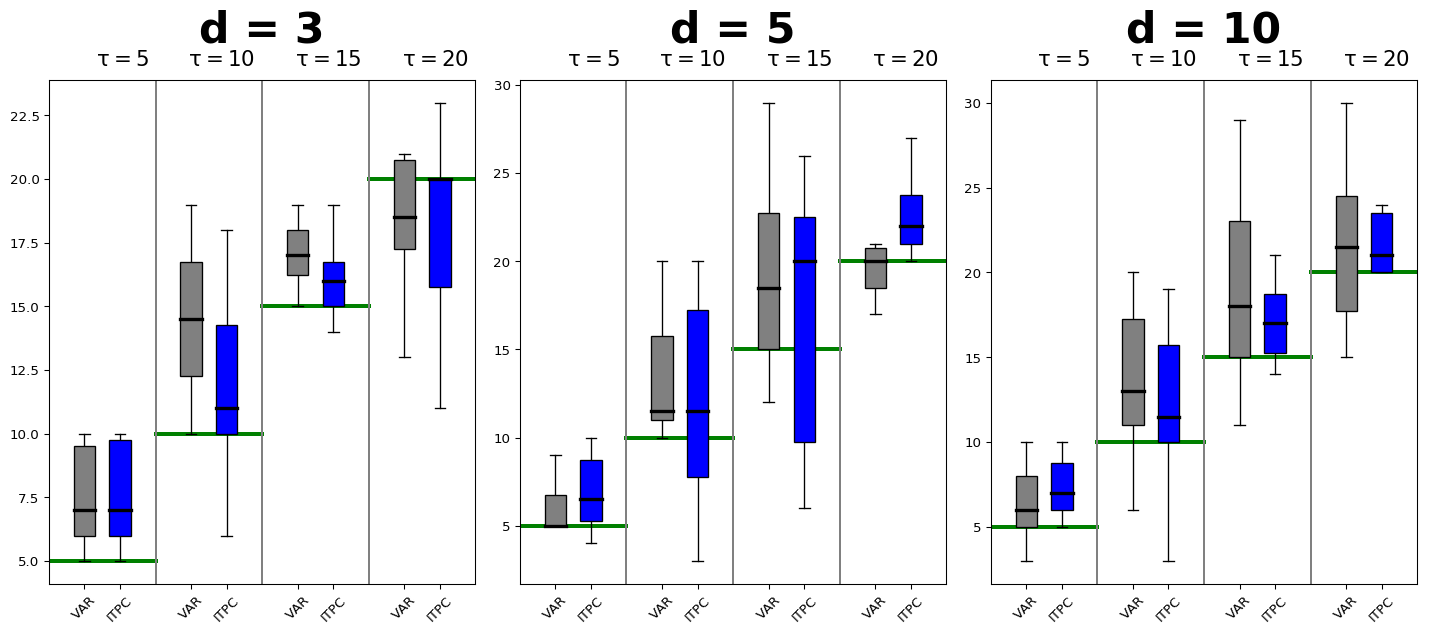

In [677]:
from itertools import product

results_path = 'notebooks/ICML/icml_results_v2/'
results = pd.read_csv(results_path + 'experiment4_aggregated_new.csv')
results['incoming edges'] = results['edges']
our_col = 'PC1 incremental tau estimate'
our_label = 'ITPC'
comp_cols = ['VAR tau estimate']
comp_labels = ['VAR']
baseline_col = 'max time lag'

comparison_box_plot_dim(results, comp_cols, comp_labels, our_col, our_label, baseline_col)

#comparison_bar_plot(results, comp_cols, comp_labels, our_col, our_label, baseline_col)

## MSE full: VAR vs. ITPC

/home/Daniel.Thevessen/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


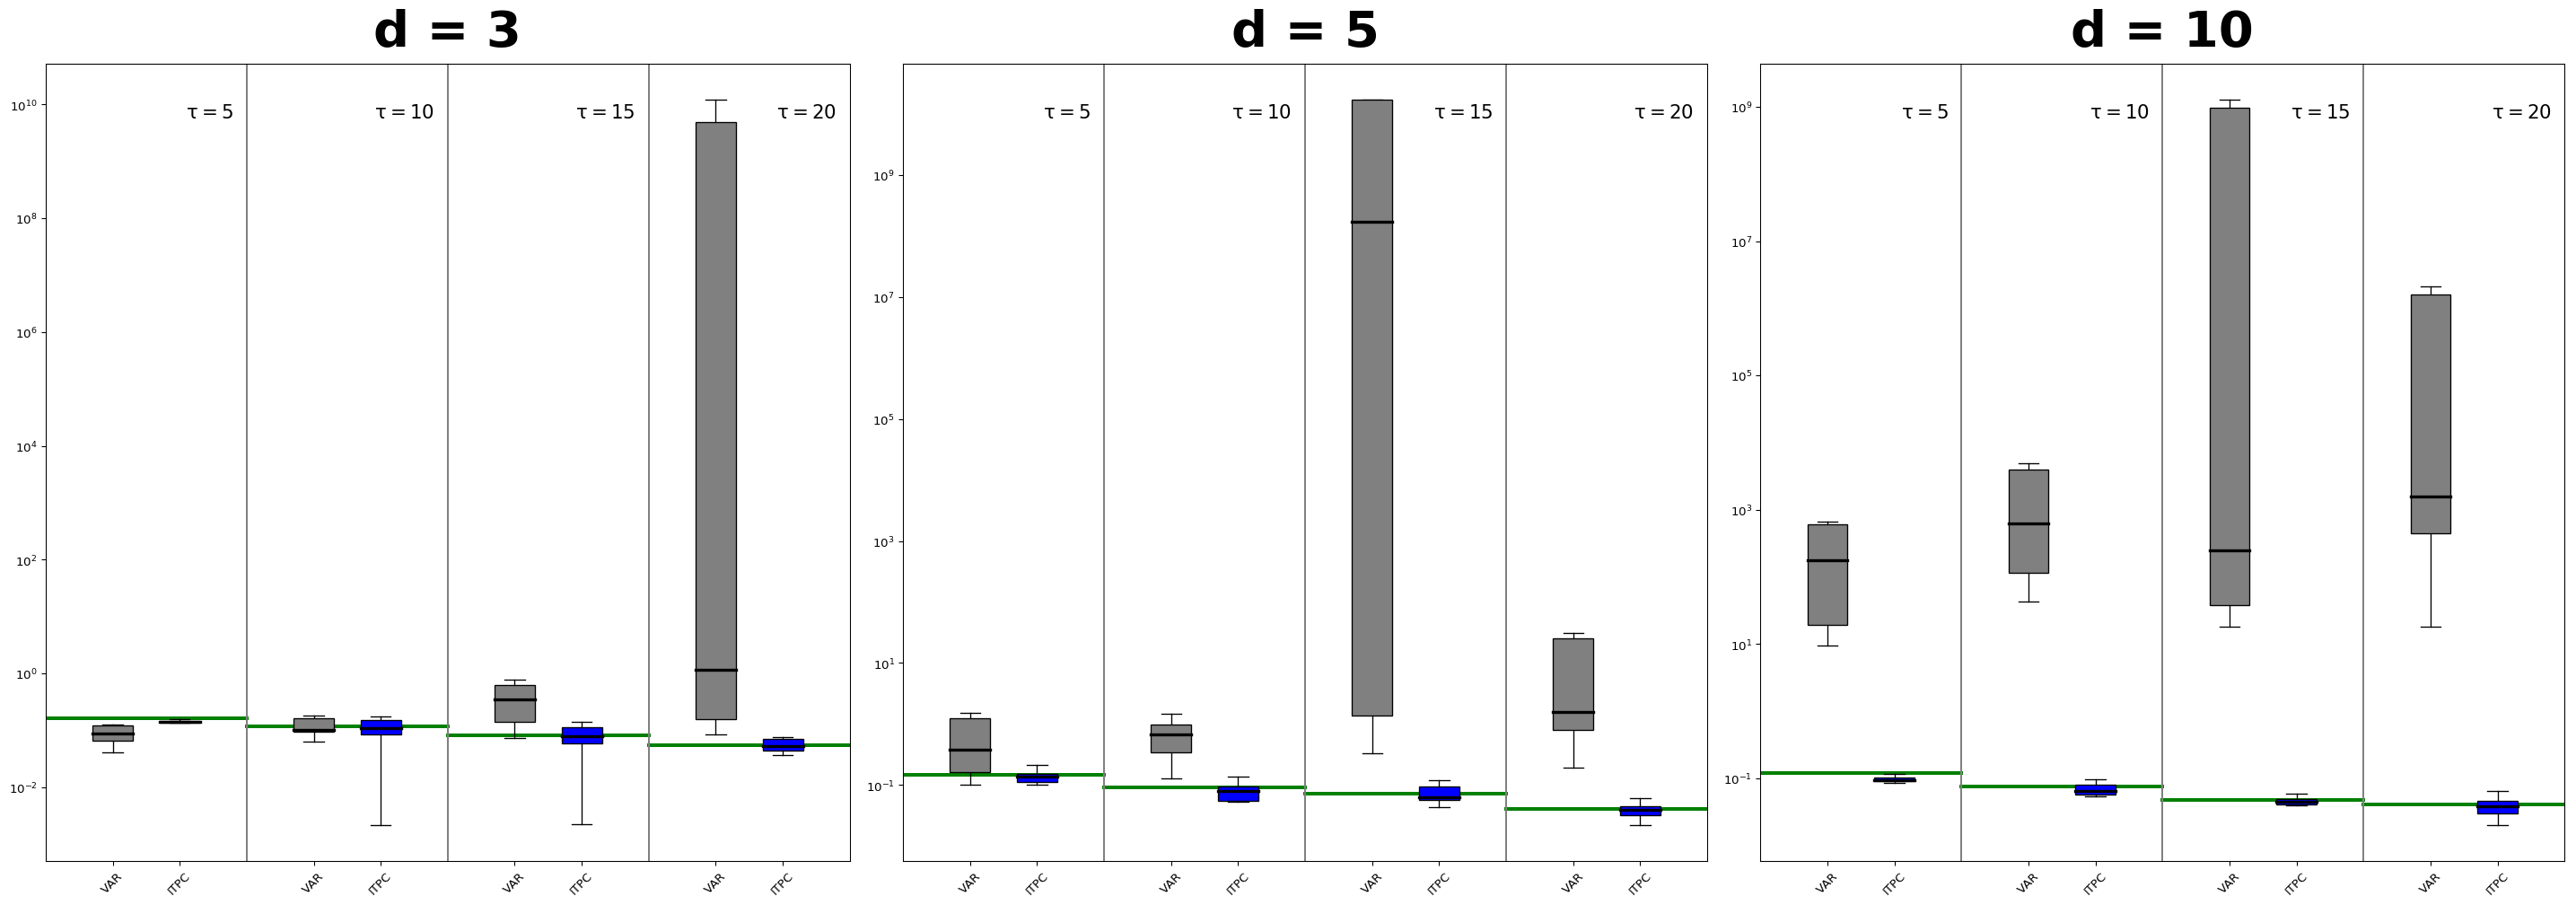

In [639]:
results_path = 'notebooks/ICML/icml_results_v2/'
results = pd.read_csv(results_path + 'experiment4_aggregated_new.csv')
results['incoming edges'] = results['edges']
our_col = 'PC1 incremental - MSE full'
our_label = 'ITPC'
comp_cols = ['VAR tau - MSE full']
comp_labels = ['VAR']
baseline_col = 'PC1 true tau - MSE full'

# comparison_box_plot_dim(results, comp_cols, comp_labels, our_col, our_label, log=True, sqrt=True)

comparison_box_plot_dim(results, comp_cols, comp_labels, our_col, our_label, baseline_col, log=True, sqrt=True)

## MSE TR: VAR vs. ITPC

/home/Daniel.Thevessen/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


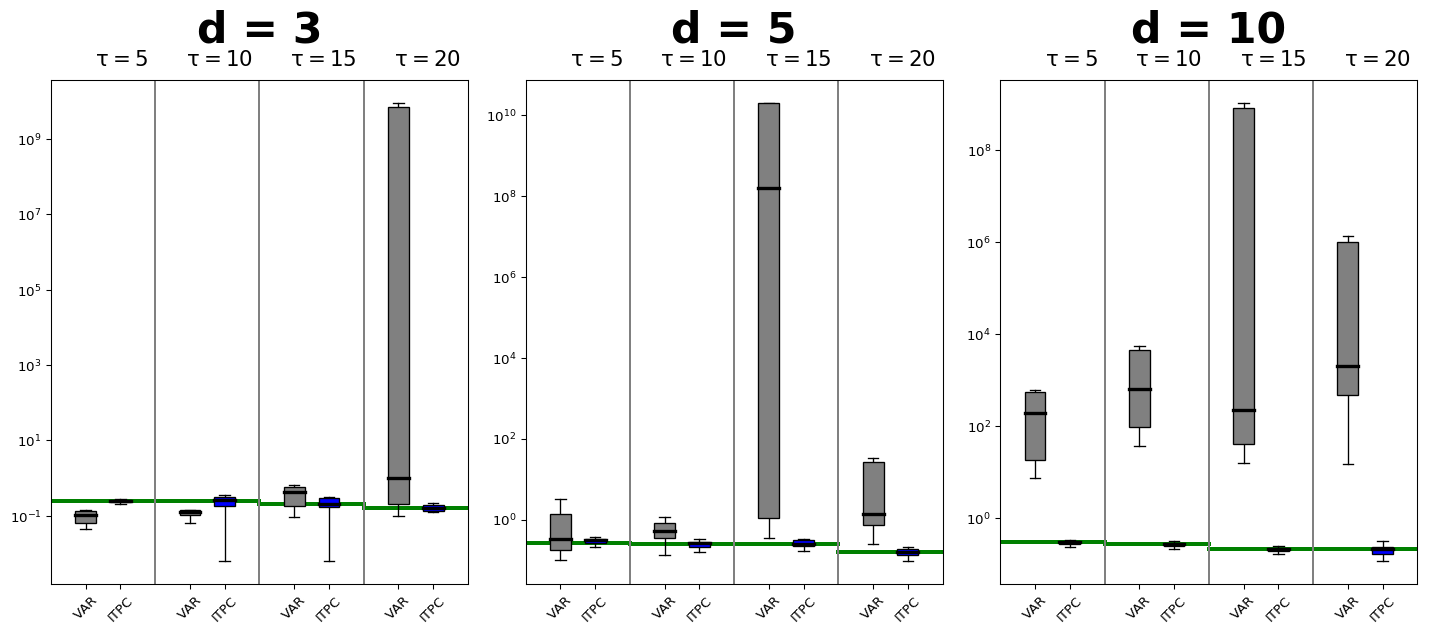

In [676]:
results_path = 'notebooks/ICML/icml_results_v2/'
results = pd.read_csv(results_path + 'experiment4_aggregated_new.csv')
results['incoming edges'] = results['edges']
our_col = 'PC1 incremental - MSE TR'
our_label = 'ITPC'
comp_cols = ['VAR tau - MSE TR']
comp_labels = ['VAR']
baseline_col = 'PC1 true tau - MSE TR'

comparison_box_plot_dim(results, comp_cols, comp_labels, our_col, our_label, baseline_col, 
                        log=True, sqrt=True)

#comparison_bar_plot(results, comp_cols, comp_labels, our_col, our_label, baseline_col, log=True)

## MSE full: PC1 with VAR estimate vs. ITPC (baseline: PC1 true $\tau$)

/home/Daniel.Thevessen/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


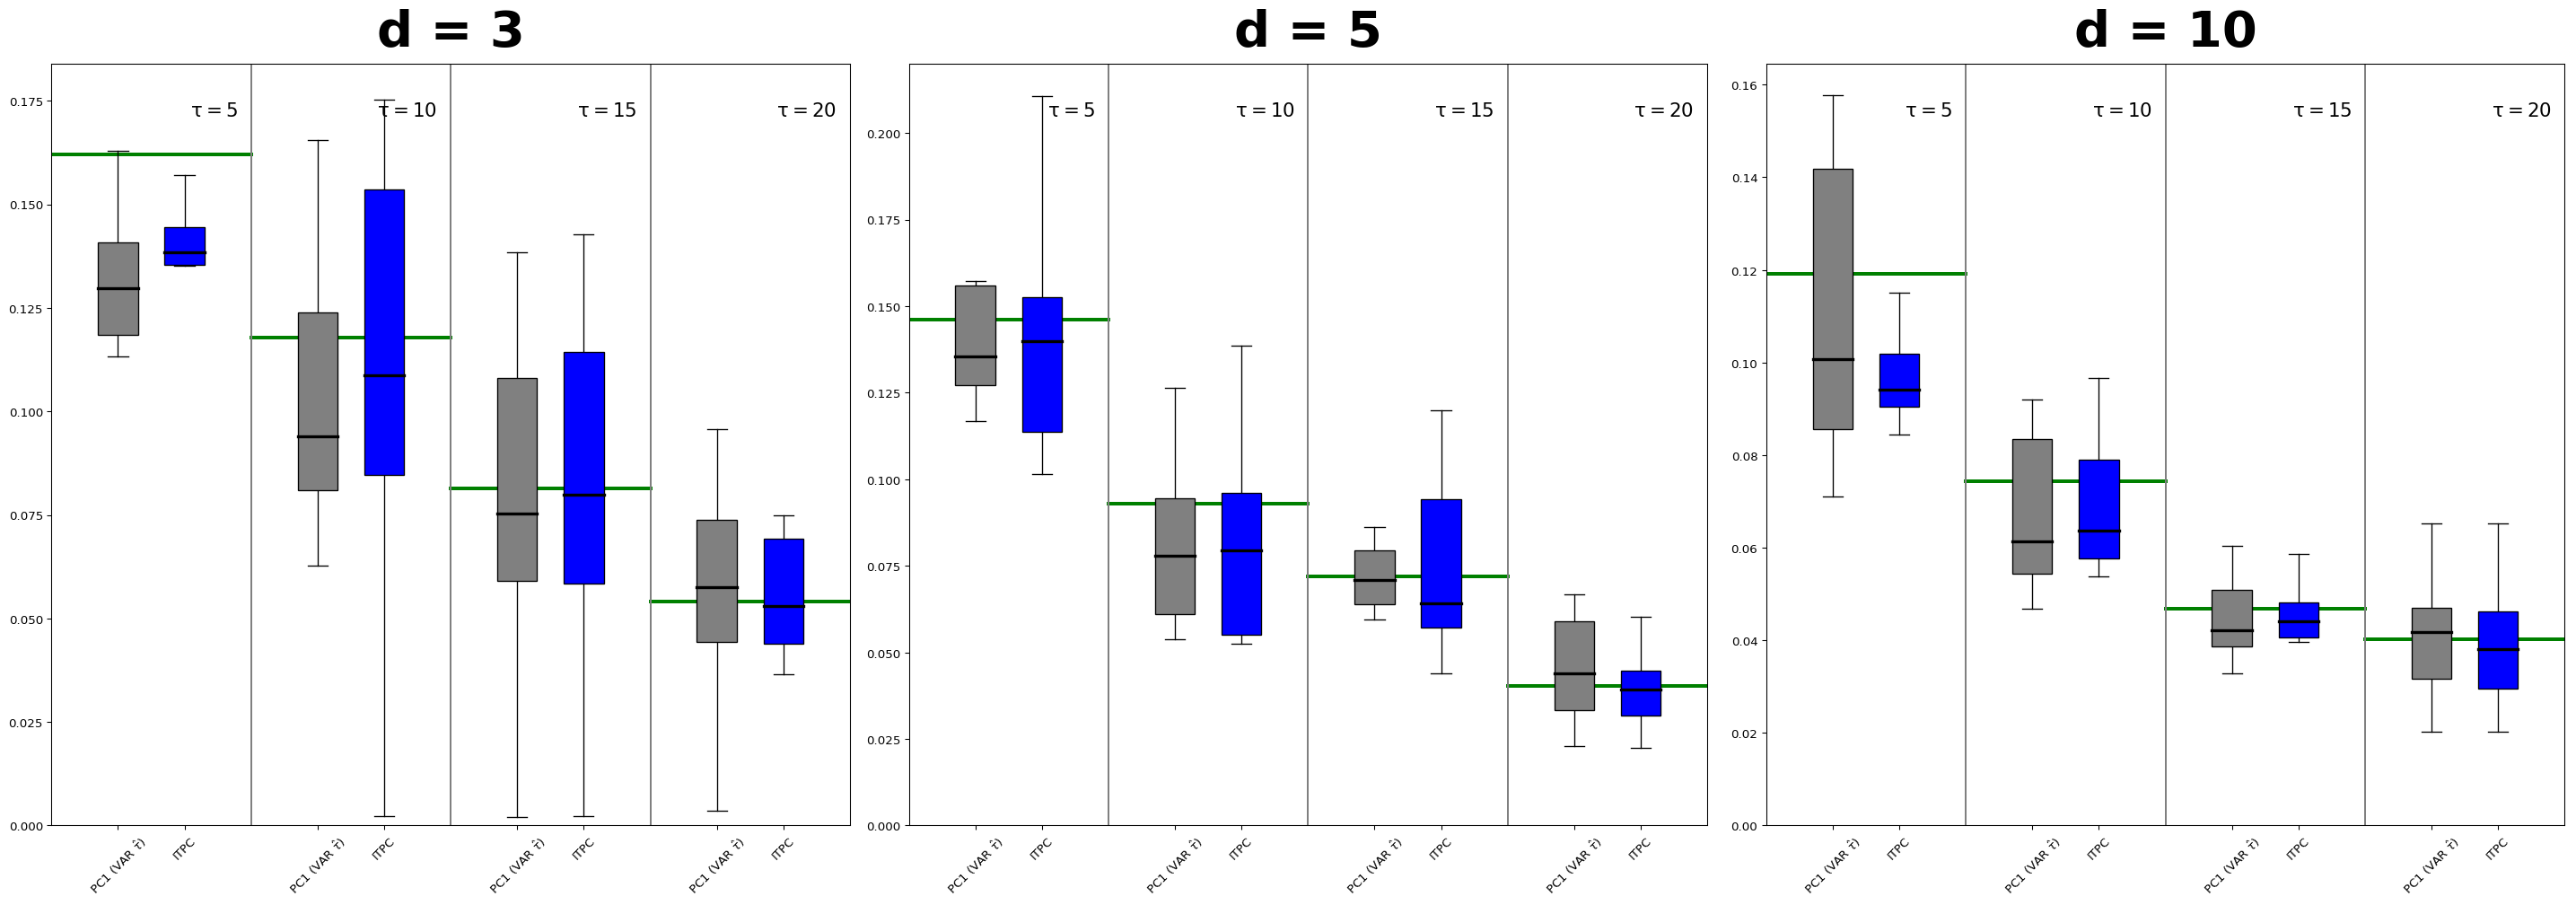

In [634]:
results_path = 'notebooks/ICML/icml_results_v2/'
results = pd.read_csv(results_path + 'experiment4_aggregated_new.csv')
results['incoming edges'] = results['edges']
our_col = 'PC1 incremental - MSE full'
our_label = 'ITPC'
comp_cols = ['PC1 var tau - MSE full']
comp_labels = ['PC1 (VAR $\\hat{\\tau}$)']
baseline_col = 'PC1 true tau - MSE full'

comparison_box_plot_dim(results, comp_cols, comp_labels, our_col, our_label, baseline_col, sqrt=True, ylim=(0,None))

#comparison_bar_plot(results, comp_cols, comp_labels, our_col, our_label, baseline_col)

## MSE TR: PC1 with VAR estimate vs. ITPC (baseline: PC1 true $\tau$)

/home/Daniel.Thevessen/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


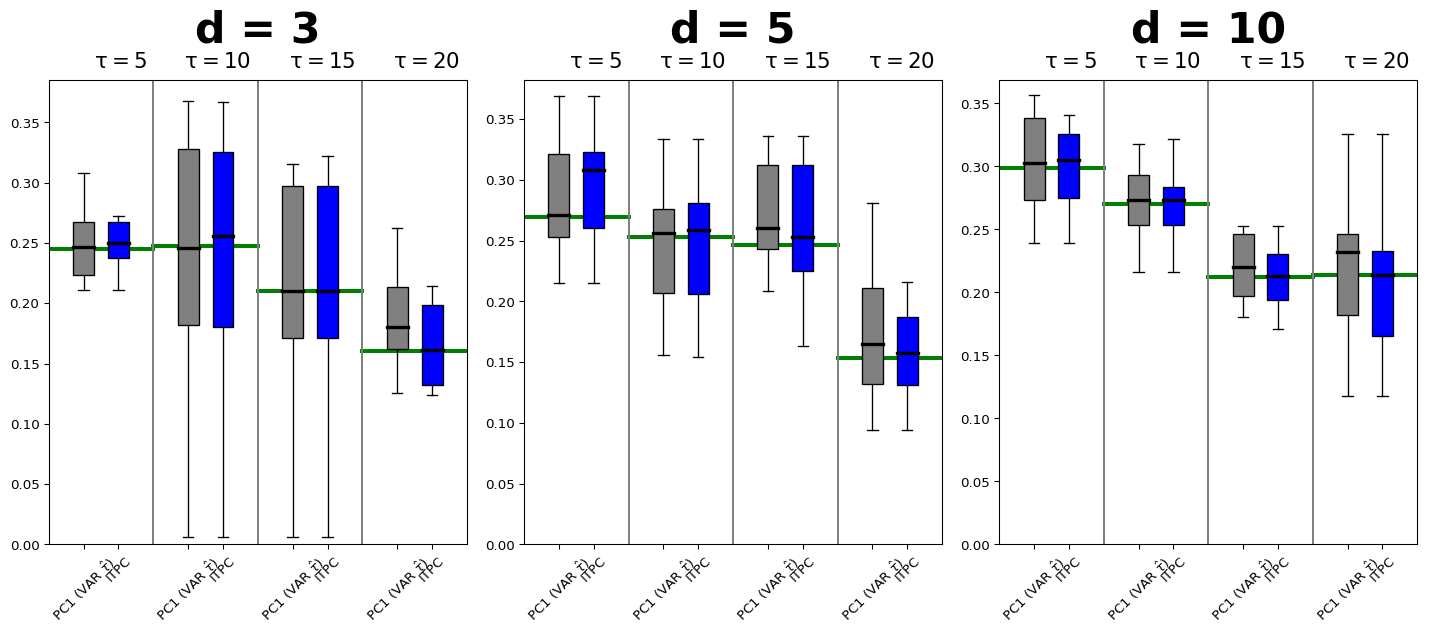

In [678]:
results_path = 'notebooks/ICML/icml_results_v2/'
results = pd.read_csv(results_path + 'experiment4_aggregated_new.csv')
results['incoming edges'] = results['edges']
our_col = 'PC1 incremental - MSE TR'
our_label = 'ITPC'
comp_cols = ['PC1 var tau - MSE TR']
comp_labels = ['PC1 (VAR $\\hat{\\tau}$)']
baseline_col = 'PC1 true tau - MSE TR'

comparison_box_plot_dim(results, comp_cols, comp_labels, our_col, our_label, baseline_col, sqrt=True, ylim=(0,None))

#comparison_bar_plot(results, comp_cols, comp_labels, our_col, our_label, baseline_col)

## F1 of PC1 with true $\tau (\pm 1)$ vs. ITPC

In [581]:
# results['ratio'] = results['PC1 incremental - MSE ']
results.groupby(['autocorr', 'graph_density', 'max time lag'])[['PC1 incremental - TPR']].mean()

PC1 incremental - TPR
autocorr graph_density max time lag                       
0.0      0.100000      20.0                       0.541053
         0.133333      15.0                       0.748148
         0.150000      20.0                       0.729700
         0.200000      10.0                       0.607310
                       15.0                       0.751429
                       20.0                       0.818931
         0.266667      15.0                       0.813761
         0.300000      10.0                       0.736176
         0.400000      5.0                        0.647032
                       10.0                       0.804422
         0.600000      5.0                        0.699432
         0.800000      5.0                        0.665048
1.0      0.100000      20.0                       0.667407
         0.133333      15.0                       0.725489
         0.150000      20.0                       0.729207
         0.200000      10.0                       0.648851
                       15.0                       0.747692
                       20.0                       0.754893
         0.266667      15.0                       0.711098
         0.300000      10.0                       0.694823
         0.400000      5.0                        0.630054
                       10.0                       0.705539
         0.600000      5.0                        0.631769
         0.800000      5.0                        0.584507

/home/Daniel.Thevessen/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


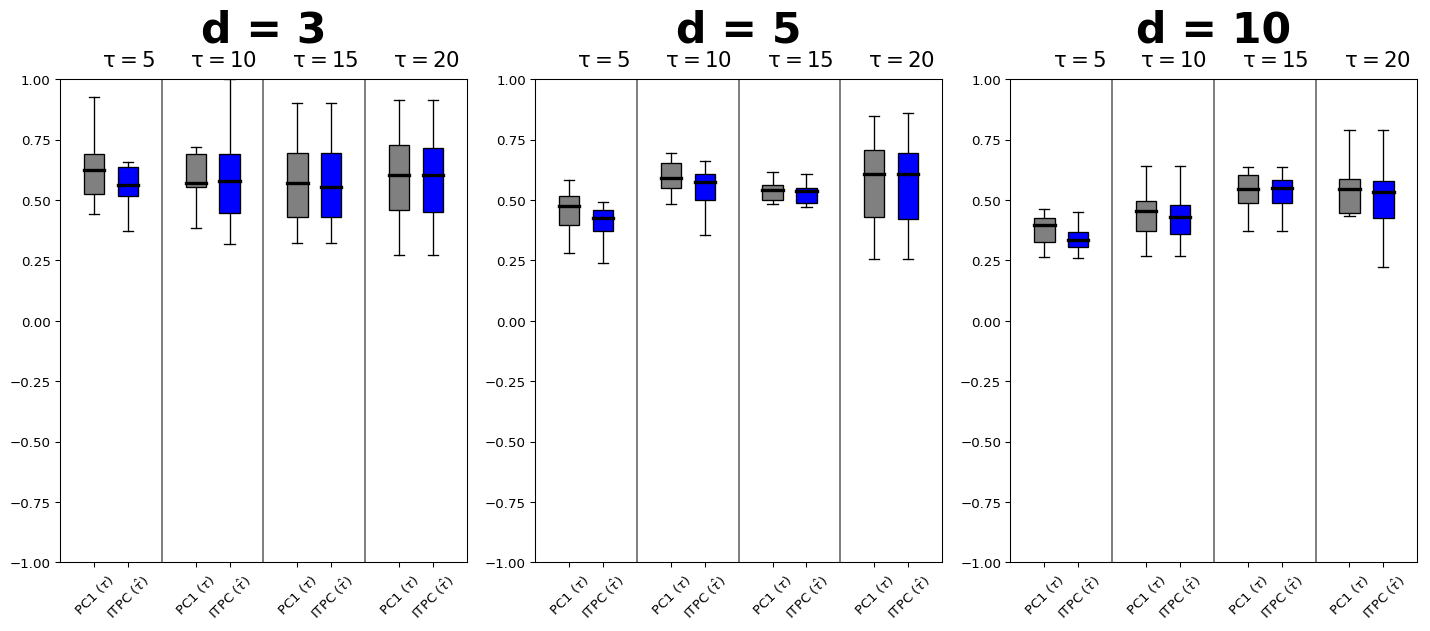

In [672]:
results_path = 'notebooks/ICML/icml_results_v2/'
results = pd.read_csv(results_path + 'experiment5.csv')
results['graph_size'] = (results['max time lag'] + 1) * results['dimension']
results['graph_density'] = results['incoming edges'] / results['max time lag']
# results['ratio'] = results['PC1 incremental - f1-score'] - results['PC1 tau - f1-score']
our_col = 'PC1 incremental - matthews_corrcoef'
our_label = 'ITPC ($\\hat{\\tau}$)'
comp_cols = ['PC1 tau - matthews_corrcoef']
comp_labels = ['PC1 ($\\tau$)']

comparison_box_plot_dim(results, comp_cols, comp_labels, our_col, our_label, ylim=(-1, 1))

In [ ]:
results

## RMSE TR of PC1 with true $\tau$ vs. ITPC

/home/Daniel.Thevessen/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


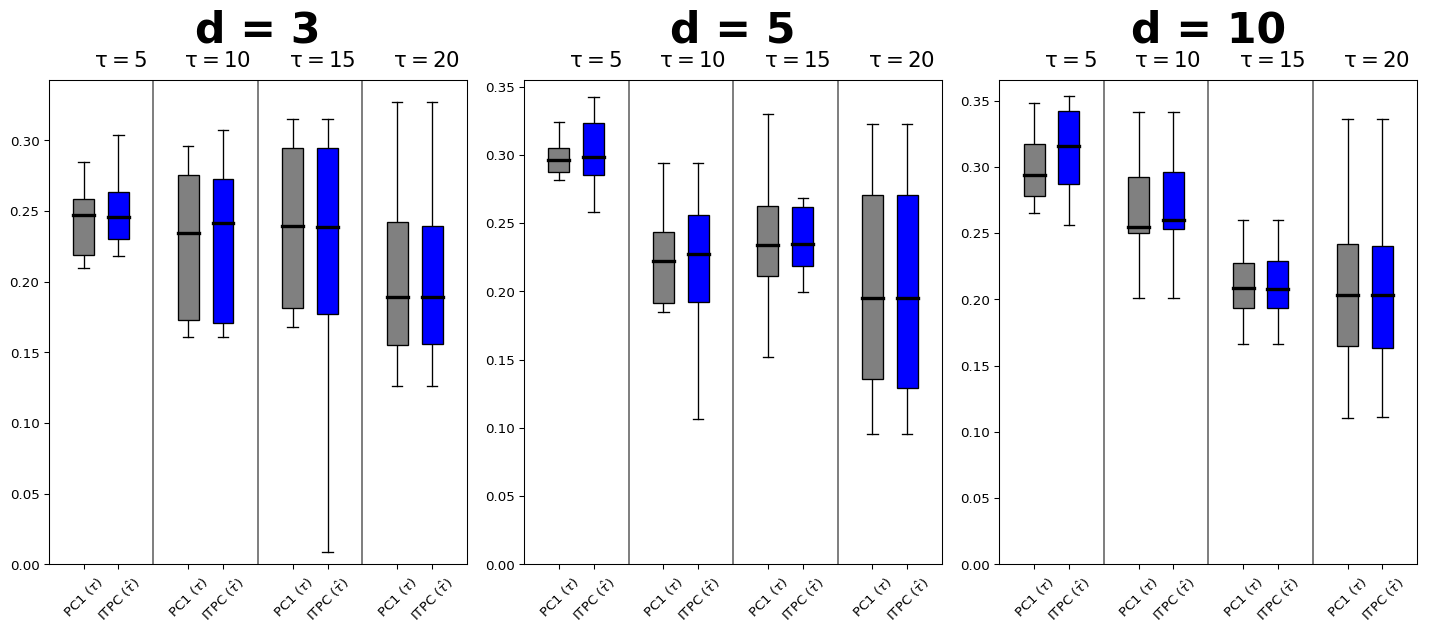

In [679]:
results_path = 'notebooks/ICML/icml_results_v2/'
results = pd.read_csv(results_path + 'experiment5.csv')
our_col = 'PC1 incremental - MSE TR'
our_label = 'ITPC ($\\hat{\\tau}$)'
comp_cols = ['PC1 tau - MSE TR']
comp_labels = ['PC1 ($\\tau$)']

comparison_box_plot_dim(results, comp_cols, comp_labels, our_col, our_label, sqrt=True, ylim=(0, None))

In [671]:
def comparison_box_plot_dim(results, comp_cols, comp_labels, our_col, our_label, baseline_col=None, ylim=None, log=False, sqrt=False):

    fig, axes = plt.subplots(1, len(dimensions), 
                            figsize=(15,6), dpi=96)
    for col_idx, dim in enumerate(dimensions):
        ax = axes[col_idx]

        cmp_cnt = 1 + len(comp_cols)

        positions = np.delete(np.arange((cmp_cnt+1)*len(taus)-1), 
                              np.arange(cmp_cnt, (cmp_cnt+1)*len(taus)-1, cmp_cnt+1)) 

        all_box_data = []
        all_tick_labels = []
        all_colors = []
        for plt_idx, tau in enumerate(taus):
            plt_data = results[(results[['dimension', 'max time lag', 'incoming edges', 'autocorr'
                                         ]].values == (dim, tau, 4, True)).all(axis=1)]

            for c in comp_cols + [our_col]:
                all_box_data.append(np.sqrt(plt_data[c]) if sqrt else plt_data[c])

            all_colors.extend(['grey']*len(comp_cols) + ['blue'])

            all_tick_labels.extend(comp_labels + [our_label])
            ax.annotate(r'$\mathrm{\tau = ' + str(tau) + r'}$', xy=((cmp_cnt+1)*plt_idx + (cmp_cnt - 0.2), 1.06),
                        xycoords=('data', 'axes fraction'), fontsize=16,
                        horizontalalignment='right', va='top')

            if baseline_col is not  None:
                baseline = (np.sqrt(plt_data[baseline_col]) if sqrt else plt_data[baseline_col]).median()
                ax.axhline(baseline, xmin=plt_idx/len(taus), xmax=(plt_idx + 1)/len(taus), linewidth=3,
                           color='green')


        for sep_idx in np.arange(cmp_cnt, (cmp_cnt+1)*len(taus)-1, cmp_cnt+1):
            ax.axvline(sep_idx, color='grey')

        medianprops = dict(linewidth=2.5, color='black')
        bps = ax.boxplot(all_box_data, positions=positions, labels=all_tick_labels, showfliers=False,
                         widths=[0.6]*len(positions), patch_artist=True, medianprops=medianprops)

        for patch, color in zip(bps['boxes'], all_colors):
            patch.set_facecolor(color)

        ax.tick_params(axis='x', rotation=45)

        ax.set_xlim(-1, max(positions)+1)
        if ylim is not None:
            ax.set_ylim(ylim)
        if log:
            ax.set_yscale('log')


    pad = 28
    for ax, col in zip(axes, [f'd = {dim}' for dim in dimensions]):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    fontsize=32, ha='center', va='baseline', fontweight='bold')

#     for ax, row in zip(axes[:1], [f'L = 4 * d' for dim in dimensions]):
#         ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                     xycoords=ax.yaxis.label, textcoords='offset points',
#                     fontsize=42, ha='right', va='center', fontweight='bold')

    plt.tight_layout()
    fig.show()

## Runtime (unused)

In [253]:
results_path = 'notebooks/ICML/icml_results_v2/'
results = pd.read_csv(results_path + 'experiment5b.csv')
results.columns

Index(['PC1 incremental - runtime', 'PC1 tau - runtime', 'PC1 tau+1 - runtime',
       'PC1 tau+2 - runtime', 'PC1 tau-1 - runtime', 'PC1 tau-2 - runtime',
       'autocorr', 'dimension', 'incoming edges', 'max time lag', 'run'],
      dtype='object')

/home/Daniel.Thevessen/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


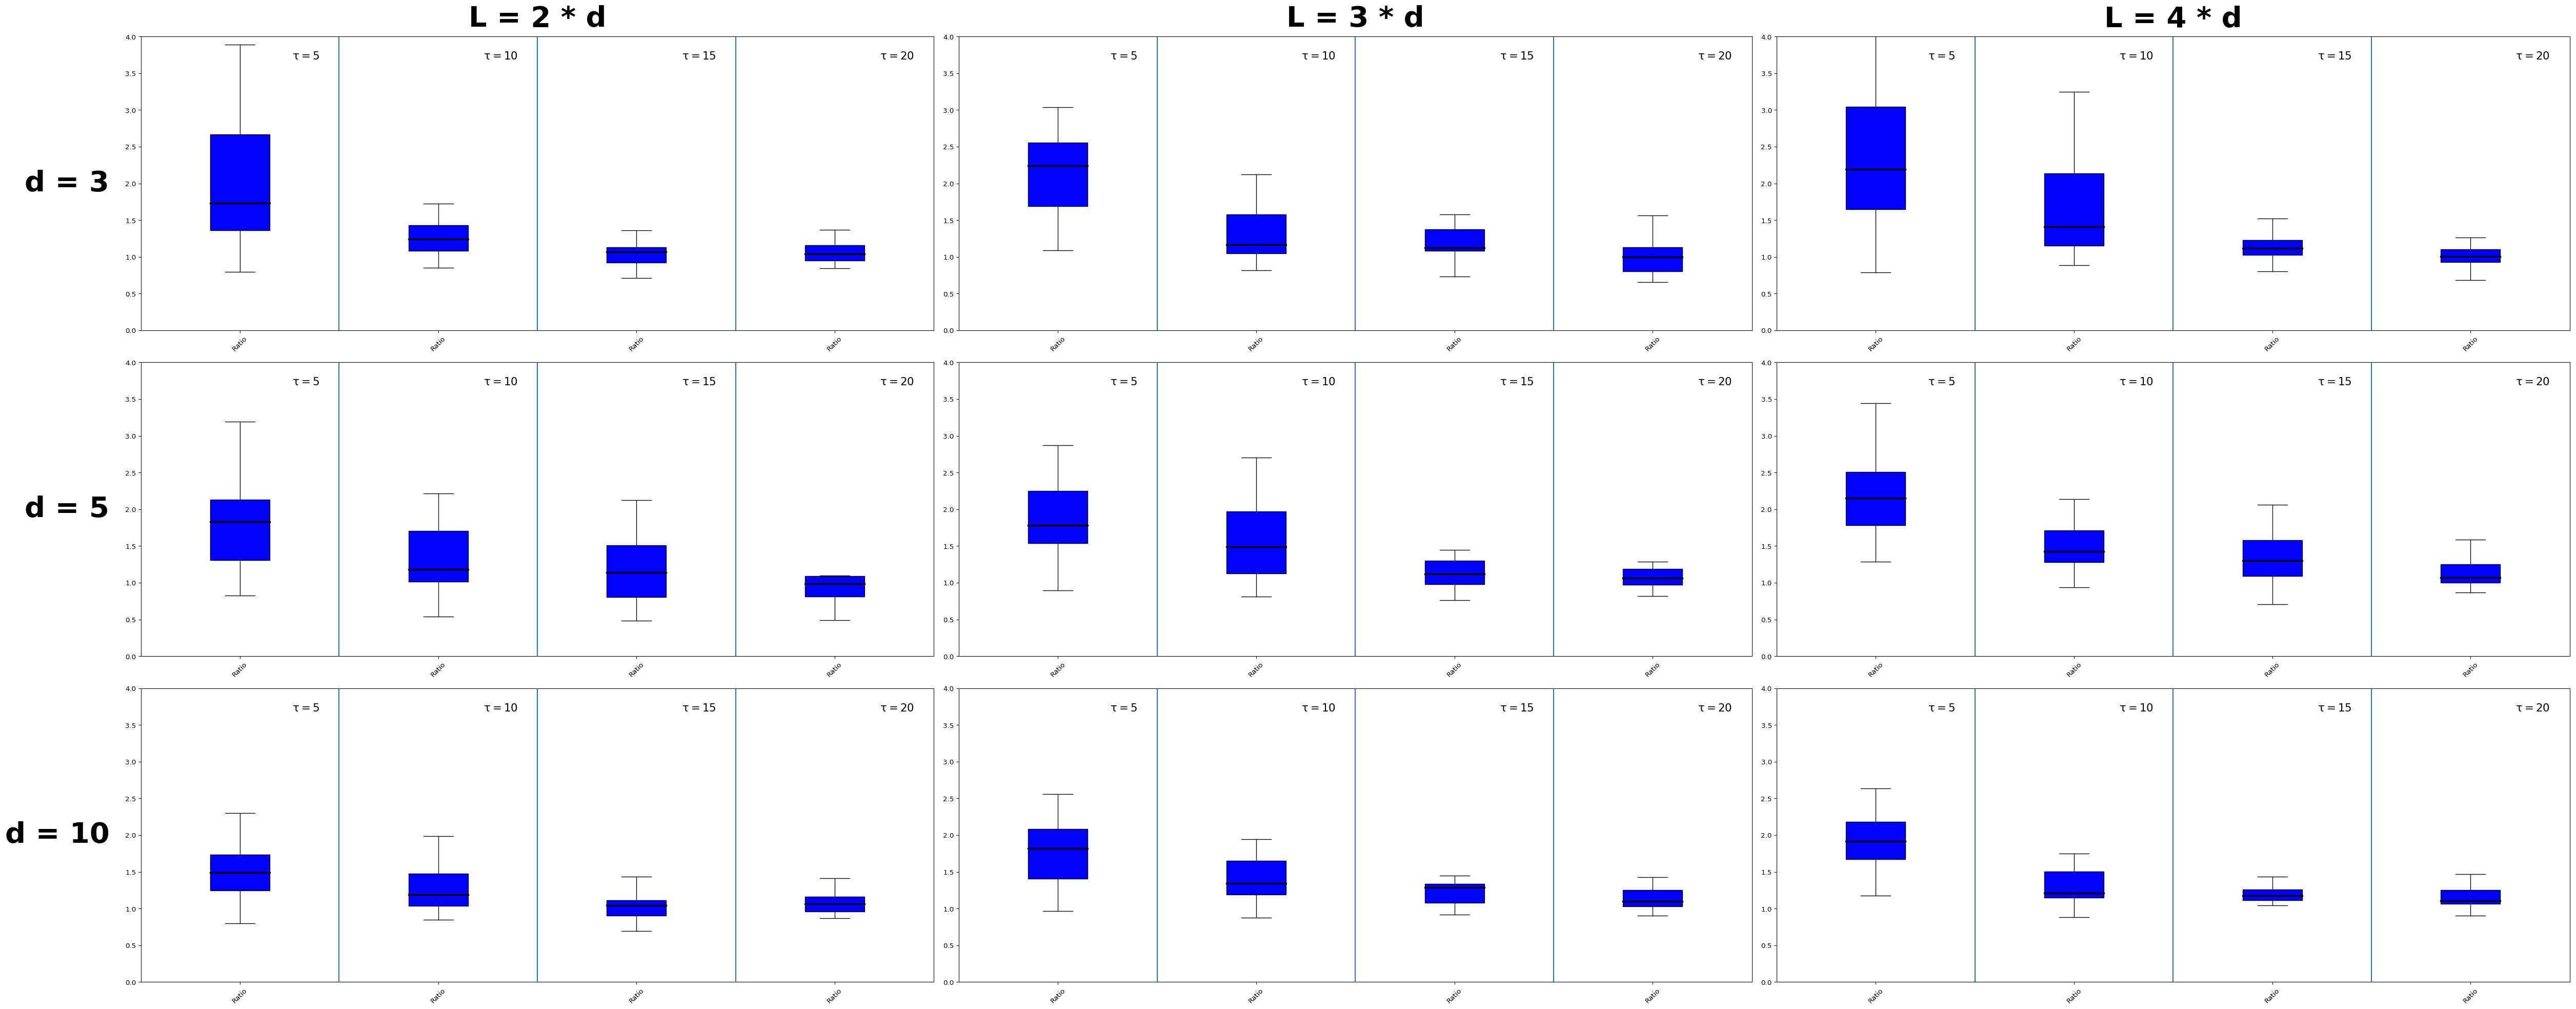

In [291]:
results_path = 'notebooks/ICML/icml_results_v2/'
results = pd.read_csv(results_path + 'experiment5b.csv')
results['ratio'] = results['PC1 incremental - runtime'] / results['PC1 tau - runtime']
our_col = 'ratio'
our_label = 'Ratio'
comp_cols = []
comp_labels = []

comparison_box_plot(results, comp_cols, comp_labels, our_col, our_label, ylim=(0, 4))

In [546]:
results['graph_size'] = (results['max time lag'] + 1) * results['dimension']
results['graph_density'] = results['incoming edges'] / results['max time lag']

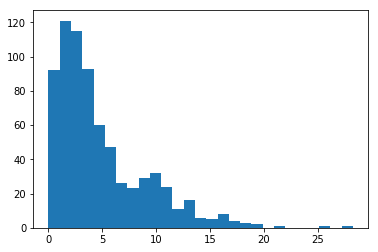

In [274]:
plt.hist(results['PC1 incremental - runtime'] / 
         ((results['max time lag'] ** 2 * results['dimension']) ** results['graph_density']), bins='auto')
plt.show()

In [288]:
results['ratio'] = results['PC1 incremental - runtime'] / results['PC1 tau - runtime']

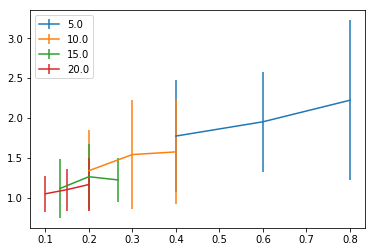

In [437]:
for group, df in results.groupby(['max time lag']):
    groups = df.groupby(['graph_density'])['ratio']

    plt.errorbar(groups.mean().index, groups.mean(), yerr=groups.std(), label=group)
plt.legend(loc=2)
plt.show()

In [428]:
results.groupby(['graph_density']).mean()['ratio']

graph_density
0.100000    1.048391
0.133333    1.114260
0.150000    1.100806
0.200000    1.255030
0.266667    1.222289
0.300000    1.540491
0.400000    1.673135
0.600000    1.951170
0.800000    2.221238
Name: ratio, dtype: float64

In [425]:
for group, df in results.groupby(['max time lag']):
    regroup = df.groupby(['graph_density']).mean()
    
    reg = LinearRegression()
    reg.fit(regroup.index.values.reshape(-1, 1), regroup['ratio'])
    print(f'{group}, intercept {reg.intercept_}, slope {reg.coef_[0]}, est. at 1: {reg.predict([[1]])}')

5.0, intercept 1.3082092037875954, slope 1.1222806623933053, est. at 1: [2.43048987]
10.0, intercept 1.1304912609191562, slope 1.1790046924461397, est. at 1: [2.30949595]
15.0, intercept 1.037634956522341, slope 0.810216582634576, est. at 1: [1.84785154]
20.0, intercept 0.9304487453686173, slope 1.160692836091768, est. at 1: [2.09114158]
